In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import time
import glob
from collections import Counter
style.use('ggplot')
import quandl
import os

In [2]:
# define a function to summarize single CSV file
def summary_from_csv_file(filename):
    
    # read in csv file
    df = pd.read_csv(filename, index_col = 0)
    
    # generate summary data frame
    summary_df = pd.DataFrame({
        "Account": [df['Account Name'][0]],
        "Created": df['Account Created Date'][0],
        "Followers Count": df['Followers Count'][0],
        "Tweets Count": len(df),
        "Start Date": df['Tweet Date'][len(df)-1],
        "End Date": df['Tweet Date'][0],
        "Account Location": df['Account Location'][0]
    }, columns = ["Account", "Created", "Tweets Count", "Start Date", "End Date",
                         "Followers Count", "Account Location"])
    
    # return data frame
    return summary_df

In [3]:
# define a function to summarize multiple CSV files in a same folder
# generate bar plot for each account
def generate_summary_table(folder):
    
    # define file path
    csvpath = os.path.join(folder, '*.csv')
    
    # generate CSV file list
    file_list = glob.glob(csvpath)
    
    # generate an empty data frame
    df = pd.DataFrame({
            "Account": [],
            "Created": [],
            "Followers Count": [],
            "Tweets Count": [],
            "Start Date": [],
            "End Date": [],
            "Account Location": []
        }, columns = ["Account", "Created", "Tweets Count", "Start Date", "End Date",
                             "Followers Count", "Account Location"])
    
    # loop through csv files, extract summary data and put together
    for file in file_list:
        summary = summary_from_csv_file(file)
        df = pd.concat([df, summary])
    
    # drop Twitter accounts with less than 100 tweets
    df = df.loc[df['Tweets Count']>100]
    df.reset_index(drop = True, inplace = True)
    
    # bar graph for how many tweets pulled
    x_axis = np.arange(len(df))
    plt.figure(figsize=(10,8))
    plt.bar(x_axis, df["Tweets Count"], align='center', tick_label= df["Account"])
    plt.xticks(rotation=90)
    plt.ylabel("Tweets Count")
    plt.title("Tweets Pulled from Each Account")
    plt.tight_layout()
    plt.savefig("Tweets_pulled.png")
    plt.show()
    
    # save data frame & return the data frame
    df.to_csv("Tweets_summary.csv")
    return df

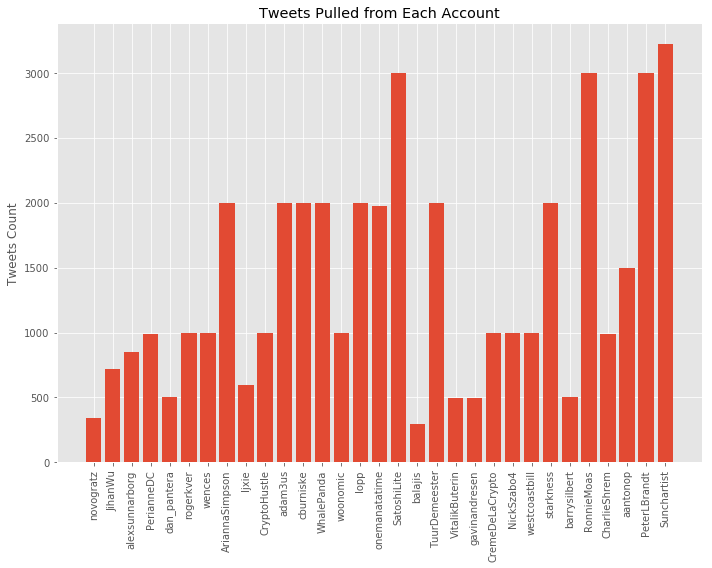

In [4]:
df = generate_summary_table("CSVfiles-individual")

In [5]:
# define a function to generate bar graph to show time frame of pulled tweets from each account

def bar_graph_for_tweets_time_coverage(dataframe):
    
    # generate empty lists
    start_dates = []
    end_dates = []
    diff_days = []
    
    # define now
    now = datetime.strptime('2018-3-18', "%Y-%m-%d")
    
    # loop through rows, convert date format and fill in the 3 lists
    for i in range(len(dataframe)):
        
        start = datetime.strptime(dataframe['Start Date'][i], "%a %b %d %H:%M:%S %z %Y")
        start_dates.append(start)
        
        end = datetime.strptime(dataframe['End Date'][i], "%a %b %d %H:%M:%S %z %Y")
        end_dates.append(end)
        
        diff = end - start
        diff_days.append(diff)

    
    # generate graph
    # define x, y
    y = range(len(dataframe))
    x = end_dates

    fig, ax = plt.subplots(figsize=(10,8))
    ax.errorbar(x, y, xerr=diff_days, 
                elinewidth=3, capsize=5, color="g", linewidth=0, xuplims = True)
    plt.yticks(y, dataframe["Account"])
    ax.yaxis.tick_right()
    plt.title("Time Frame of Downloaded Tweets")
    plt.tight_layout()
    plt.savefig("TweetsTimeFrame.png")
    plt.show()

    return diff_days

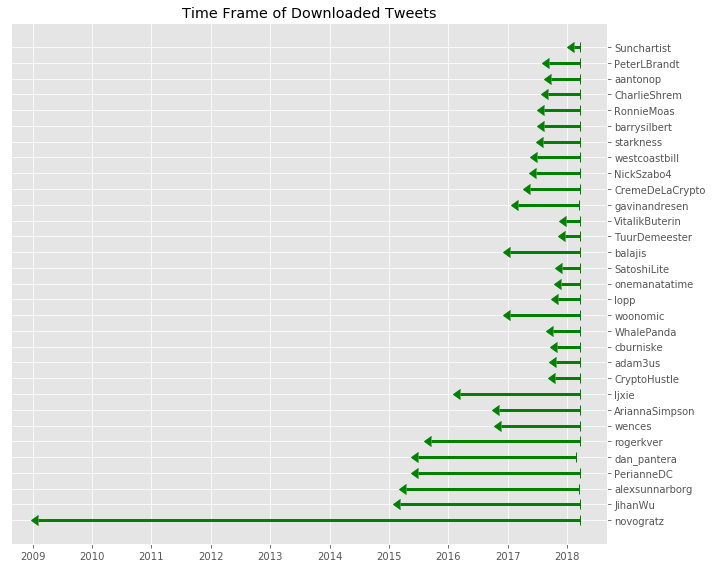

In [6]:
covered_days = bar_graph_for_tweets_time_coverage(df)

In [9]:
# define a function to generate bubble chart for Twitter accounts
def bubble_chart_of_Twitter_accounts(dataframe, covered_days):
    
    # generate empty lists to store create date (x axis for chart) & Tweet frequency (size)
    Create_date_list = []
    Tweet_freq_size = []
    
    for i in range(len(dataframe)):
        converted = datetime.strptime(dataframe["Created"][i], "%a %b %d %H:%M:%S %z %Y")
        Create_date_list.append(converted)
        
        freq = (dataframe["Tweets Count"][i]/covered_days[i].days)*7
        Tweet_freq_size.append(freq*6)
    
    # generate bubble chart, save fig, show fig
    plt.figure(figsize=(10,8))
    plt.scatter(Create_date_list, dataframe["Followers Count"], c='g', s=Tweet_freq_size, edgecolors="r")
    plt.yscale('log')
    plt.title("Twitter Account Information")
    plt.ylabel("Follower Count")
    plt.xlabel("Account Creation Date")
    plt.legend(["Tweets \n Frequency"], loc='upper left', markerscale=0.3, fancybox = True, edgecolor="black")
    plt.tight_layout()
    plt.savefig("TwitterAccount.png")
    plt.show()
    return Create_date_list

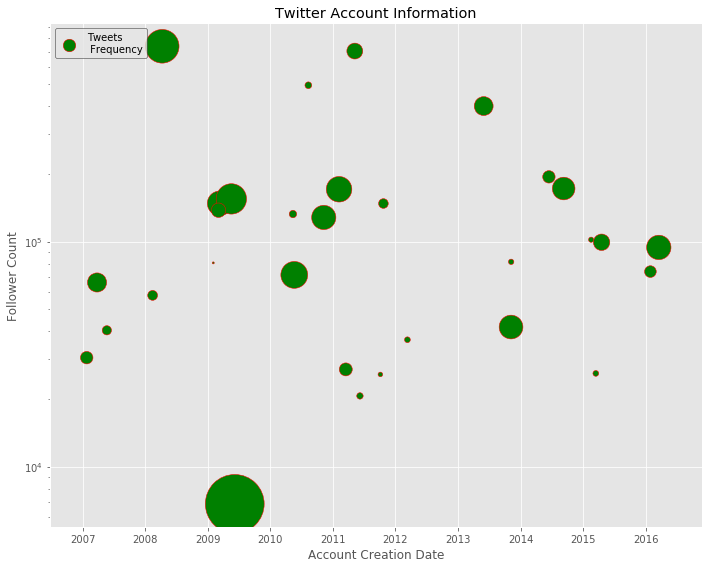

In [10]:
Create_date_list = bubble_chart_of_Twitter_accounts(df, covered_days)

In [11]:
# define a function check trend of account setup with bitcoin price
def Twitter_acc_accum_vs_bitcoin(Create_date_list):
    
    # calculation accounts accumulation
    Create_date_list.sort()
    acc_accum = []
    count = 1
    for date in Create_date_list:
        acc_accum.append(count)
        count = count + 1
    
    # read in bitcoin price info, calculate x axis for bitcoin price
    coin = pd.read_csv("bitcoinPrice.csv", index_col = 0)
    Coin_x_axis = []
    for i in range(len(coin)):
        date = datetime.strptime(coin['Date'][i], "%Y-%m-%d")
        Coin_x_axis.append(date)
    
    # generate plots for both, save fig and show fig
    fig, ax1 = plt.subplots(figsize = (10, 8))
    color = 'tab:red'
    ax1.set_ylabel('USD', color=color)
    ax1.plot(Coin_x_axis, coin['Close'], label = "Bitcoin Price")
    ax1.set_yscale('log')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accum Account Number', color=color)
    ax2.plot(Create_date_list, acc_accum, marker = "o", color = "b", markersize = 3.0,
                label = "Twitter Accounts")

    ax2.tick_params(axis='y', labelcolor=color)
    
    ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.95))
    plt.tight_layout()
    plt.savefig("AccountvsPrice.png")
    plt.show()

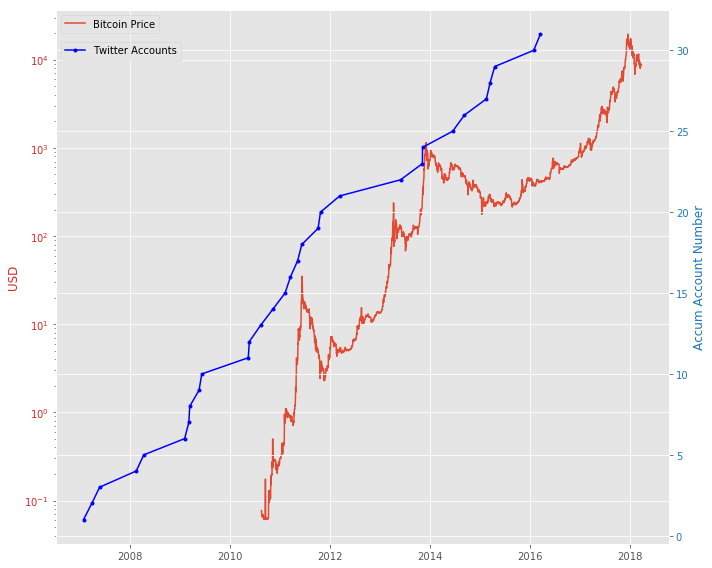

In [12]:
Twitter_acc_accum_vs_bitcoin(Create_date_list)